In [1]:
from qiskit.visualization import plot_histogram
from born.qbm import run_generative_optimization

-- Initialize Quantum Born Machine --
-- Training with cnot parameterization --
-- Generating targets --
-- Setting initial condiitons --
-- Performing PSO --
Iteration 2: 1.315160
FINAL: 1.315160
-- Run quantum circuit --
-- Output histogram --


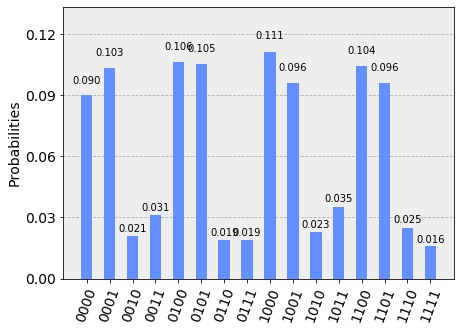

In [2]:
# Run QC training and optimization
learned = run_generative_optimization()
print("-- Output histogram --")
plot_histogram(learned)